This is the attempt to do custom objective Asymmetric MSE to penalize over predictions

import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

import matplotlib.pyplot as plt


First, read the pre-split data

In [2]:
# Load the pre-split data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()  # Convert to Series
y_test = pd.read_csv('../data/y_test.csv').squeeze()    # Convert to Series

In [3]:
print(X_train.shape)

(329, 28)


In [64]:
# Check data types
print(X_train.dtypes)


resistance_line                     float64
support_line                        float64
start_date                           object
end_date                             object
num_candles                         float64
price_range_pct                     float64
num_res_hits                        float64
num_sup_hits                        float64
num_res_breakouts                   float64
num_sup_breakouts                   float64
alternation                         float64
last_candle_return                  float64
last_candle_pct_above_support       float64
resistance_hits                      object
support_hits                         object
breakout_type                        object
concentration_score                 float64
customer_pre_sideway_bar_change     float64
customer_post_sideway_bar_change    float64
pre_sideway_5_bar_change            float64
pre_sideway_10_bar_change           float64
pre_sideway_22_bar_change           float64
pre_sideway_44_bar_change       

In [65]:
print(y_train.dtypes)

float64


In [66]:
# Check for missing values
print(X_train.isnull().sum())
print(y_train.isnull().sum())

resistance_line                     0
support_line                        0
start_date                          0
end_date                            0
num_candles                         0
price_range_pct                     0
num_res_hits                        0
num_sup_hits                        0
num_res_breakouts                   0
num_sup_breakouts                   0
alternation                         0
last_candle_return                  0
last_candle_pct_above_support       0
resistance_hits                     0
support_hits                        0
breakout_type                       0
concentration_score                 0
customer_pre_sideway_bar_change     0
customer_post_sideway_bar_change    2
pre_sideway_5_bar_change            0
pre_sideway_10_bar_change           0
pre_sideway_22_bar_change           0
pre_sideway_44_bar_change           0
pre_sideway_132_bar_change          0
post_sideway_5_bar_change           0
concentration_score_scaled          0
alternation_

Defining custom loss function here

In [67]:
def asymmetric_loss(y_true, y_pred, alpha=1, beta=2):
    '''
    Beta >> Alpha where Beta is the weight to penalize the overprediction
    '''
    diff = y_true - y_pred
    loss = np.where(diff > 0, alpha * (diff**2), beta * (diff**2))
    return np.mean(loss)

asymmetric_scorer = make_scorer(asymmetric_loss, 
                                greater_is_better=False, 
                                alpha=1, 
                                beta=2)

Initialization of feature sets and models / hyperparameter grids

In [68]:
# Define the feature sets to experiment with
feature_sets = {
    'Feature_Set_1': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return',
       'last_candle_pct_above_support',
       'concentration_score_scaled', 'alternation_score_scaled'],
    'Feature_Set_2': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return',
       'last_candle_pct_above_support'],
    'Feature_Set_3': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return'],
    'Feature_Set_4': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return',
       'last_candle_pct_above_support',
       'concentration_score_scaled', 'alternation_score_scaled',
       'pre_sideway_5_bar_change', 'pre_sideway_10_bar_change'],
    'Feature_Set_5': ['num_candles','price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts',
       'num_sup_breakouts', 'alternation', 'last_candle_return',
       'last_candle_pct_above_support',
       'concentration_score_scaled', 'alternation_score_scaled',
       'pre_sideway_5_bar_change', 'pre_sideway_10_bar_change',
       'pre_sideway_22_bar_change', 'pre_sideway_44_bar_change',
       'pre_sideway_132_bar_change'
       ]
    # Add more feature sets as needed
}
# feature set 1 is everything
# feature set 2 is based on feature importance and domain
# feature set 3 is reduction of feature set 2
# feature set 4 is feature set 1 + presideways bar change (5,10) since no missing values
# feature set 5 is feature set 1 + all presideway bar changes (5,10,22,44,132) where imputation of missing values handled with 0

# Define models and hyperparameter grids
models_and_params = {
    'Linear Regression': {
        'model': LinearRegression(),
        'param_grid': {}  # No hyperparameters to tune for Linear Regression
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.2],
            'subsample': [0.8, 1.0]
        }
    },
    'Lasso Regression': {
        'model': Lasso(random_state=42),
        'param_grid': {
            'alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    'Ridge Regression': {
        'model': Ridge(random_state=42),
        'param_grid': {
            'alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    'Elastic Net Regression': {
        'model': ElasticNet(random_state=42),
        'param_grid': {
            'alpha': [0.01, 0.1, 1.0, 10.0],
            'l1_ratio': [0.2, 0.5, 0.8]  # Controls L1 vs. L2 contribution
        }
    }
}

Search for best-performing model for each feature-set and overall

In [69]:
from tqdm import tqdm

# Initialize a results list
results = []

# Wrap the outer loop (feature sets) with tqdm
for feature_set_name, feature_set in tqdm(feature_sets.items(), desc="Feature Sets"):
    print(f"\nProcessing Feature Set: {feature_set_name} with features: {feature_set}")
    
    # Select the relevant features for the current feature set
    X_train_subset = X_train[feature_set]
    X_test_subset = X_test[feature_set]
    
    # Wrap the inner loop (models) with tqdm
    for model_name, model_info in tqdm(models_and_params.items(), desc=f"Models for {feature_set_name}", leave=False):
        print(f"  Training Model: {model_name}")
        model = model_info['model']
        param_grid = model_info['param_grid']
        
        # Perform hyperparameter tuning (if applicable)
        if param_grid:
            print(f"    Performing Grid Search for {model_name}...")
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                       scoring=asymmetric_scorer, 
                                       cv=5, 
                                       n_jobs=-1)
            grid_search.fit(X_train_subset, y_train)
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            print(f"    Best Params for {model_name}: {best_params}")
        else:
            # For models with no hyperparameter tuning (e.g., Linear Regression)
            model.fit(X_train_subset, y_train)
            best_model = model
            best_params = {}
        
        # Make predictions
        y_pred = best_model.predict(X_test_subset)  # Add this line to compute predictions
        
        # Evaluate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        asymmetric_loss_value = asymmetric_loss(y_test, y_pred)  # Use your custom loss function
        r2 = r2_score(y_test, y_pred)

        # Print metrics (optional for debugging)
        print(f"    {model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, Asymmetric Loss: {asymmetric_loss_value:.4f}, R^2: {r2:.4f}")

        # Append all metrics to results
        results.append({
            'Feature_Set': feature_set_name,
            'Model': model_name,
            'Best_Params': best_params,
            'MSE': mse,
            'MAE': mae,
            'Asymmetric_Loss': asymmetric_loss_value,
            'R^2': r2
        })

Feature Sets:   0%|          | 0/5 [00:00<?, ?it/s]


Processing Feature Set: Feature_Set_1 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return', 'last_candle_pct_above_support', 'concentration_score_scaled', 'alternation_score_scaled']


  Training Model: Linear Regression
    Linear Regression - MSE: 0.0008, MAE: 0.0209, Asymmetric Loss: 0.0013, R^2: 0.4168
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
    Random Forest - MSE: 0.0006, MAE: 0.0180, Asymmetric Loss: 0.0010, R^2: 0.5371
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


    Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
    XGBoost - MSE: 0.0007, MAE: 0.0193, Asymmetric Loss: 0.0013, R^2: 0.4524
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0010, MAE: 0.0218, Asymmetric Loss: 0.0017, R^2: 0.2834
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 10.0}
    Ridge Regression - MSE: 0.0008, MAE: 0.0207, Asymmetric Loss: 0.0013, R^2: 0.4226
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...


Feature Sets:  20%|██        | 1/5 [00:17<01:11, 17.94s/it]

    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0007, MAE: 0.0200, Asymmetric Loss: 0.0012, R^2: 0.4399

Processing Feature Set: Feature_Set_2 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return', 'last_candle_pct_above_support']


  Training Model: Linear Regression
    Linear Regression - MSE: 0.0008, MAE: 0.0210, Asymmetric Loss: 0.0013, R^2: 0.4151
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
    Random Forest - MSE: 0.0006, MAE: 0.0179, Asymmetric Loss: 0.0010, R^2: 0.5663
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


    Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
    XGBoost - MSE: 0.0007, MAE: 0.0193, Asymmetric Loss: 0.0012, R^2: 0.4677
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0010, MAE: 0.0218, Asymmetric Loss: 0.0017, R^2: 0.2834
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 10.0}
    Ridge Regression - MSE: 0.0008, MAE: 0.0207, Asymmetric Loss: 0.0013, R^2: 0.4225
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...


Feature Sets:  40%|████      | 2/5 [00:24<00:33, 11.25s/it]

    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0007, MAE: 0.0200, Asymmetric Loss: 0.0012, R^2: 0.4399

Processing Feature Set: Feature_Set_3 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return']


  Training Model: Linear Regression
    Linear Regression - MSE: 0.0011, MAE: 0.0248, Asymmetric Loss: 0.0019, R^2: 0.1697
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
    Random Forest - MSE: 0.0010, MAE: 0.0231, Asymmetric Loss: 0.0017, R^2: 0.2535
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


    Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
    XGBoost - MSE: 0.0010, MAE: 0.0240, Asymmetric Loss: 0.0017, R^2: 0.2434
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0014, MAE: 0.0273, Asymmetric Loss: 0.0025, R^2: -0.0585
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 0.01}
    Ridge Regression - MSE: 0.0011, MAE: 0.0248, Asymmetric Loss: 0.0019, R^2: 0.1664
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...


Feature Sets:  60%|██████    | 3/5 [00:30<00:17,  8.70s/it]

    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0014, MAE: 0.0269, Asymmetric Loss: 0.0024, R^2: -0.0252

Processing Feature Set: Feature_Set_4 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return', 'last_candle_pct_above_support', 'concentration_score_scaled', 'alternation_score_scaled', 'pre_sideway_5_bar_change', 'pre_sideway_10_bar_change']


  Training Model: Linear Regression
    Linear Regression - MSE: 0.0008, MAE: 0.0214, Asymmetric Loss: 0.0014, R^2: 0.3886
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}
    Random Forest - MSE: 0.0006, MAE: 0.0173, Asymmetric Loss: 0.0009, R^2: 0.5818
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


    Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
    XGBoost - MSE: 0.0007, MAE: 0.0192, Asymmetric Loss: 0.0012, R^2: 0.4579
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0010, MAE: 0.0218, Asymmetric Loss: 0.0017, R^2: 0.2834
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 10.0}
    Ridge Regression - MSE: 0.0008, MAE: 0.0207, Asymmetric Loss: 0.0013, R^2: 0.4237
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...


Feature Sets:  80%|████████  | 4/5 [00:41<00:09,  9.56s/it]

    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0007, MAE: 0.0200, Asymmetric Loss: 0.0012, R^2: 0.4399

Processing Feature Set: Feature_Set_5 with features: ['num_candles', 'price_range_pct', 'num_res_hits', 'num_sup_hits', 'num_res_breakouts', 'num_sup_breakouts', 'alternation', 'last_candle_return', 'last_candle_pct_above_support', 'concentration_score_scaled', 'alternation_score_scaled', 'pre_sideway_5_bar_change', 'pre_sideway_10_bar_change', 'pre_sideway_22_bar_change', 'pre_sideway_44_bar_change', 'pre_sideway_132_bar_change']


  Training Model: Linear Regression
    Linear Regression - MSE: 0.0008, MAE: 0.0208, Asymmetric Loss: 0.0013, R^2: 0.3984
  Training Model: Random Forest
    Performing Grid Search for Random Forest...


    Best Params for Random Forest: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
    Random Forest - MSE: 0.0006, MAE: 0.0179, Asymmetric Loss: 0.0010, R^2: 0.5461
  Training Model: XGBoost
    Performing Grid Search for XGBoost...


Feature Sets: 100%|██████████| 5/5 [00:52<00:00, 10.42s/it]

    Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
    XGBoost - MSE: 0.0008, MAE: 0.0195, Asymmetric Loss: 0.0013, R^2: 0.4184
  Training Model: Lasso Regression
    Performing Grid Search for Lasso Regression...
    Best Params for Lasso Regression: {'alpha': 0.01}
    Lasso Regression - MSE: 0.0010, MAE: 0.0218, Asymmetric Loss: 0.0017, R^2: 0.2834
  Training Model: Ridge Regression
    Performing Grid Search for Ridge Regression...
    Best Params for Ridge Regression: {'alpha': 10.0}
    Ridge Regression - MSE: 0.0007, MAE: 0.0204, Asymmetric Loss: 0.0012, R^2: 0.4379
  Training Model: Elastic Net Regression
    Performing Grid Search for Elastic Net Regression...
    Best Params for Elastic Net Regression: {'alpha': 0.01, 'l1_ratio': 0.2}
    Elastic Net Regression - MSE: 0.0007, MAE: 0.0200, Asymmetric Loss: 0.0012, R^2: 0.4399


In [70]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df.head(10)

,Feature_Set,Model,Best_Params,MSE,MAE,Asymmetric_Loss,R^2
0,Feature_Set_1,Linear Regression,{},0.000776,0.020895,0.001260,0.416764
1,Feature_Set_1,Random Forest,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.000616,0.017986,0.001023,0.537071
2,Feature_Set_1,XGBoost,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.000728,0.019300,0.001254,0.452383
3,Feature_Set_1,Lasso Regression,{'alpha': 0.01},0.000953,0.021837,0.001662,0.283446
4,Feature_Set_1,Ridge Regression,{'alpha': 10.0},0.000768,0.020690,0.001259,0.422606
5,Feature_Set_1,Elastic Net Regression,"{'alpha': 0.01, 'l1_ratio': 0.2}",0.000745,0.020000,0.001238,0.439890
6,Feature_Set_2,Linear Regression,{},0.000778,0.020962,0.001262,0.415055
7,Feature_Set_2,Random Forest,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.000577,0.017923,0.000966,0.566299
8,Feature_Set_2,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.000708,0.019317,0.001237,0.467676
9,Feature_Set_2,Lasso Regression,{'alpha': 0.01},0.000953,0.021837,0.001662,0.283446


Find the overall best model based on Asymmetric Loss

In [71]:
overall_best = results_df.loc[results_df['Asymmetric_Loss'].idxmin()]

# Display the overall best model
print("\nOverall Best Model Based on Asymmetric Loss:")
print(overall_best[['Feature_Set', 'Model', 'Best_Params', 'Asymmetric_Loss']])


Overall Best Model Based on Asymmetric Loss:
Feature_Set                                            Feature_Set_4
Model                                                  Random Forest
Best_Params        {'max_depth': 5, 'min_samples_split': 5, 'n_es...
Asymmetric_Loss                                             0.000923
Name: 19, dtype: object


Find the best model (minimum Asymmetric Loss) for each feature set


In [80]:
best_per_feature_set = results_df.loc[results_df.groupby('Feature_Set')['Asymmetric_Loss'].idxmin()]

# Display the best models for each feature set
print("\nBest Model for Each Feature Set Based on Minimum Asymmetric Loss:")
best_per_feature_set[['Feature_Set', 'Model', 'Asymmetric_Loss','MSE','MAE','R^2']]


Best Model for Each Feature Set Based on Minimum Asymmetric Loss:


,Feature_Set,Model,Asymmetric_Loss,MSE,MAE,R^2
1,Feature_Set_1,Random Forest,0.001023,0.000616,0.017986,0.537071
7,Feature_Set_2,Random Forest,0.000966,0.000577,0.017923,0.566299
14,Feature_Set_3,XGBoost,0.001735,0.001006,0.023958,0.243368
19,Feature_Set_4,Random Forest,0.000923,0.000556,0.017288,0.581758
25,Feature_Set_5,Random Forest,0.001000,0.000604,0.017861,0.546075


Grouped Bar Plot Comparing Models for Each Feature Set

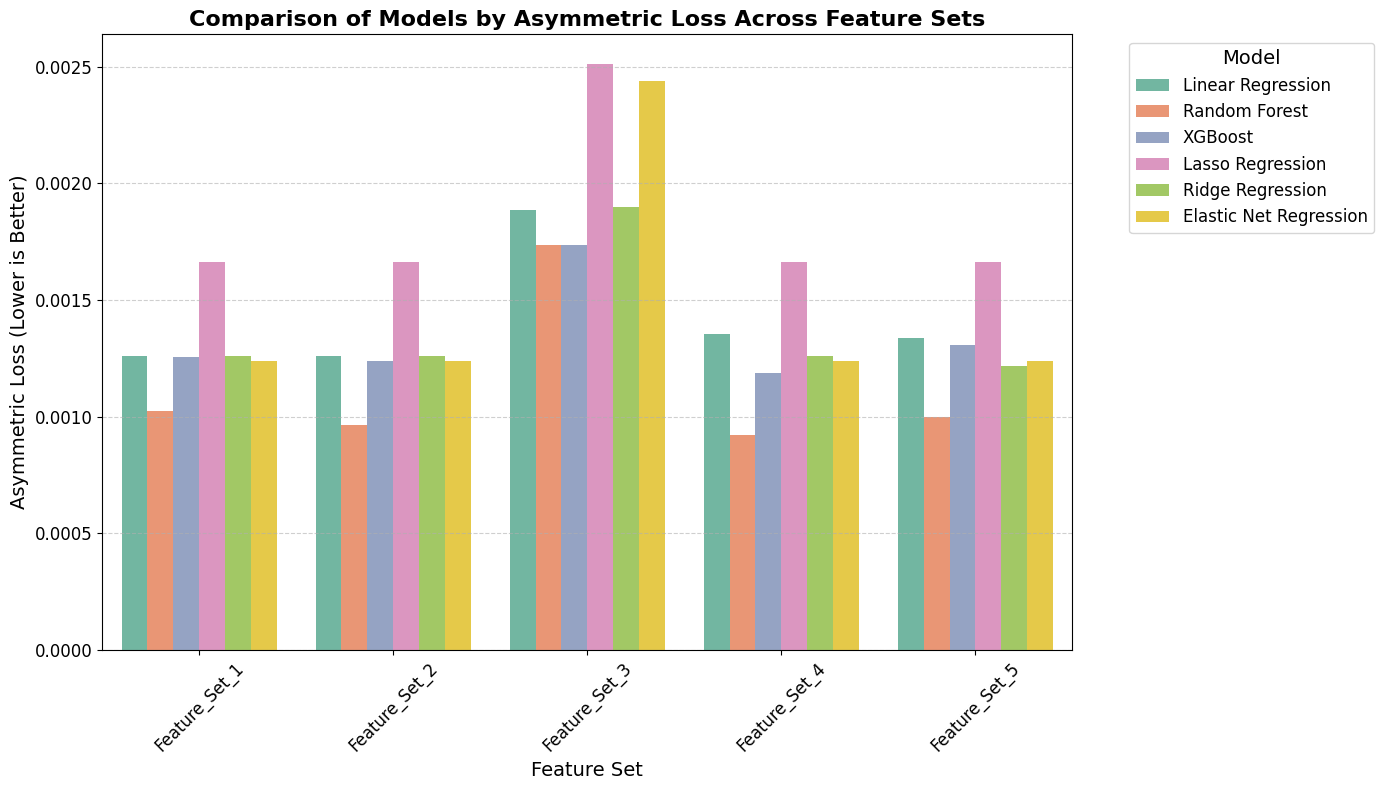

In [73]:
# Calculate the average Asymmetric Loss for each Feature Set
average_loss_per_set = results_df.groupby('Feature_Set')['Asymmetric_Loss'].mean().reset_index()

# Use a visually appealing color palette
palette = "Set2"  # Alternative options: "Set1", "Paired", "pastel"

plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='Feature_Set', y='Asymmetric_Loss', hue='Model', palette=palette)
plt.title('Comparison of Models by Asymmetric Loss Across Feature Sets', fontsize=16, fontweight='bold')
plt.xlabel('Feature Set', fontsize=14)
plt.ylabel('Asymmetric Loss (Lower is Better)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Model', title_fontsize=14, fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [74]:
average_loss_per_set

,Feature_Set,Asymmetric_Loss
0,Feature_Set_1,0.001283
1,Feature_Set_2,0.001271
2,Feature_Set_3,0.002035
3,Feature_Set_4,0.001270
4,Feature_Set_5,0.001294


In [75]:
# Summary of best models for each feature set
summary_df = best_per_feature_set[['Feature_Set', 'Model', 'Best_Params', 'Asymmetric_Loss']].sort_values(by='Asymmetric_Loss')

# Display the summary DataFrame
print("\nSummary of Best Models for Each Feature Set (Sorted by Asymmetric Loss):")
summary_df


Summary of Best Models for Each Feature Set (Sorted by Asymmetric Loss):


,Feature_Set,Model,Best_Params,Asymmetric_Loss
19,Feature_Set_4,Random Forest,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.000923
7,Feature_Set_2,Random Forest,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.000966
25,Feature_Set_5,Random Forest,"{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.001000
1,Feature_Set_1,Random Forest,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.001023
14,Feature_Set_3,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.001735


In [76]:
# Automatically select the best Random Forest model based on minimum Asymmetric Loss
best_rf_row = results_df[(results_df['Model'] == 'Random Forest')].loc[results_df['Asymmetric_Loss'].idxmin()]

# Extract the best model and feature set name
best_rf_model_name = best_rf_row['Model']
best_feature_set_name = best_rf_row['Feature_Set']

print(f"Automatically Selected Best Random Forest Model: {best_rf_model_name}")
print(f"Feature Set Used: {best_feature_set_name}")

Automatically Selected Best Random Forest Model: Random Forest
Feature Set Used: Feature_Set_4


Retraining the best model archi selected and feature set

In [77]:
# Extract the best feature set for training
best_feature_set = feature_sets[best_feature_set_name]  # Get the feature names
X_train_best = X_train[best_feature_set]
X_test_best = X_test[best_feature_set]

# Retrain the Random Forest model
from sklearn.ensemble import RandomForestRegressor

# Use the best parameters if they exist in the results table
best_params = best_rf_row['Best_Params']

# Instantiate the model with the best parameters
best_rf_model = RandomForestRegressor(random_state=42, **best_params)
best_rf_model.fit(X_train_best, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test_best)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Retrained Random Forest Model - MSE: {mse:.4f}, R^2: {r2:.4f}")

Retrained Random Forest Model - MSE: 0.0006, R^2: 0.5818


# Only can plot feature importance if its RF

Feature Importances for Best Random Forest Model:
                          Feature  Importance
8   last_candle_pct_above_support    0.590924
1                 price_range_pct    0.223354
9      concentration_score_scaled    0.057047
11       pre_sideway_5_bar_change    0.029375
12      pre_sideway_10_bar_change    0.025106
0                     num_candles    0.023974
7              last_candle_return    0.017454
3                    num_sup_hits    0.014513
2                    num_res_hits    0.006258
4               num_res_breakouts    0.006069
5               num_sup_breakouts    0.003643
10       alternation_score_scaled    0.001163
6                     alternation    0.001120


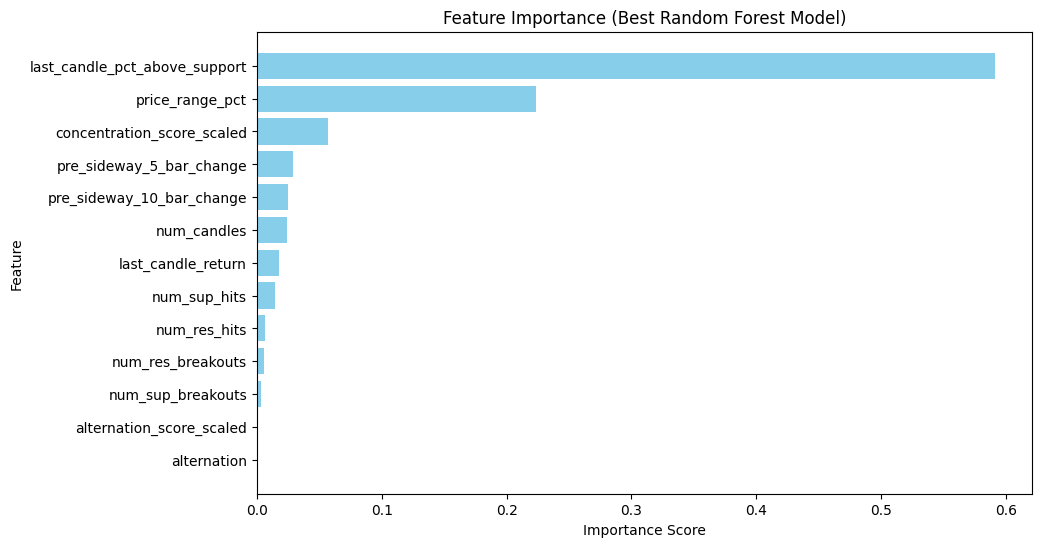

In [78]:
# Get feature importance values
feature_importances = best_rf_model.feature_importances_

# Match them with feature names
importance_df = pd.DataFrame({
    'Feature': best_feature_set,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the importance DataFrame
print("Feature Importances for Best Random Forest Model:")
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.title('Feature Importance (Best Random Forest Model)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

#1 run: Original X and Original y

Best Model for Each Feature Set:
     Feature_Set          Model       R^2       MSE
1  Feature_Set_1  Random Forest  0.159093  0.001310
4  Feature_Set_2  Random Forest  0.161914  0.001305
7  Feature_Set_3  Random Forest  0.168403  0.001295

Overall Best Model:
Feature_Set    Feature_Set_3
Model          Random Forest
R^2                 0.168403
MSE                 0.001295
Name: 7, dtype: object


#2 run: Modified X and Original y
Modified refers to excluding those "violating" sideways
Best Model for Each Feature Set:
     Feature_Set          Model       R^2       MSE
1  Feature_Set_1  Random Forest  0.491088  0.000601
4  Feature_Set_2  Random Forest  0.472735  0.000622
7  Feature_Set_3  Random Forest  0.310111  0.000814

Overall Best Model:
Feature_Set    Feature_Set_1
Model          Random Forest
R^2                 0.491088
MSE                 0.000601
Name: 1, dtype: object

#3 run: Modified X (+ exclusion of sideways longer than 220 candles) and Original y
Best Model for Each Feature Set:
     Feature_Set          Model       R^2       MSE
1  Feature_Set_1  Random Forest  0.527394  0.000629
4  Feature_Set_2  Random Forest  0.566299  0.000577
8  Feature_Set_3        XGBoost  0.243368  0.001006

Overall Best Model:
Feature_Set    Feature_Set_2
Model          Random Forest
R^2                 0.566299
MSE                 0.000577

while Feature set 2 demonstrate the best, but i think we should choose Feature set 1 -> see the feature importance ... it also uses concentration score. so next step is to improve the alternation computation because obviously here it does really use for determining the breakthrough percent change

Feature Importances for Best Random Forest Model:
                          Feature  Importance
8   last_candle_pct_above_support    0.596197
1                 price_range_pct    0.237161
9      concentration_score_scaled    0.061028
0                     num_candles    0.037345
7              last_candle_return    0.027842
3                    num_sup_hits    0.012969
4               num_res_breakouts    0.008286
2                    num_res_hits    0.008237
5               num_sup_breakouts    0.006758
6                     alternation    0.002091
10       alternation_score_scaled    0.002086



#4 run: same as #3 but 
Best Model for Each Feature Set:
      Feature_Set          Model       R^2       MSE
1   Feature_Set_1  Random Forest  0.527394  0.000629
4   Feature_Set_2  Random Forest  0.566299  0.000577
8   Feature_Set_3        XGBoost  0.243368  0.001006
10  Feature_Set_4  Random Forest  0.581758  0.000556

Overall Best Model:
['Random Forest' 'Feature_Set_4'
 {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}]